In [1]:
# import os
# os.chdir("/Users/bmhi/Desktop/research/script")
# import preprocess as pp

In [351]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import scipy.signal as signal
from scipy.interpolate import interp1d
import seaborn as sns

class EMG:
    # 基本変数の定義
    labels = ["Rt_TA", "Rt_SOL", "Rt_GM", "Rt_GL", "Rt_VM", "Rt_VL", "Rt_Ham", "Lt_TA", 
                "Lt_SOL", "Lt_GM", "Lt_GL", "Lt_VM", "Lt_VL", "Lt_Ham", "Rt_foot", "Lt_foot"]
    sampling_rate = 1000  # サンプリングレート
    low_freq = None   # ローパスフィルタ周波数
    high_freq = None  # ハイパスフィルタ周波数
    smoothing = False # 平滑化
    nyq = sampling_rate/2
    lln = False
    
    def __init__(self, fname):
        mat = sp.io.loadmat(fname)
        _dat = mat["data"]
        _start_idx = mat["datastart"]
        _end_idx = mat["dataend"]
        
        self.raw = pd.DataFrame()
        for s, e, la in zip(_start_idx, _end_idx, self.labels):
            if s == -1:
                continue
            else:
                la = la.replace(" ", "")
                self.raw[la] = _dat[0][int(s-1):int(e-1)]
        
        self.foot_sensor = self.raw.iloc[:,14:]
        self.raw.columns = self.labels
        _rt = self.raw["Rt_foot"].values
        _rt = _rt - min(_rt)
        _rt[_rt < np.max(_rt)/2] = 0
        _events = [1 if _rt[j-1] == 0 and _rt[j]>0 else 0 for j in range(len(_rt))]
        
        _lt = self.raw["Lt_foot"].values
        _lt = _lt - min(_lt)
        _lt[_lt < np.max(_lt)/2] = 0
        _events2 = [2 if _lt[j-1] == 0 and _lt[j]>0 else 0 for j in range(len(_lt))]
        
        # self.foot_sensor = self.raw.iloc[:,14:]

        self.raw["Rt_foot"] = _events
        self.raw["Lt_foot"] = _events2
        
        _events3 = self.raw.iloc[:,14:]
        self.events = _events3.max(axis=1)# eventsというイベントデータ(0: no event,1: rt_foot,2: lt_foot)
        self.foot_sensor = self.raw.iloc[:,14:]
        self.raw = self.raw.iloc[:,:14]   # rawというEMGデータ
        self.raw = self.raw - self.raw.mean()
        
    def approx(self, x, method, n):
        y = np.arange(0, len(x), 1)
        f = interp1d(y, x, kind = method)
        y_resample = np.linspace(0, len(x)-1, n)
        return f(y_resample)
    
    
    def filering(self, degree, high_freq = 0.5, low_freq = 500, btype = "bandpass"):
        self.high_freq, self.low_freq = high_freq, low_freq
        self.filtered = self.raw.copy()
        
        h_freq = high_freq/self.nyq
        l_freq = low_freq/self.nyq
        b, a = sp.signal.butter(degree, [h_freq, l_freq], btype=btype)
        for ch in self.filtered.columns:
            self.filtered[ch] = sp.signal.filtfilt(b, a, self.filtered[ch])
    
    
    
    def smooth(self, dat=None, freq=20, degree = 4, filtered = False):
        if self.smoothing and dat is None:
            ValueError("This Instance is already smoothed!")
        if dat:
            self.smoothed = dat
        elif self.high_freq == None or self.low_freq == None:
            self.smoothed = self.raw.copy()
        else:
            self.smoothed = self.filtered.copy()
        low_pass = degree/self.nyq
        
        b2, a2 = sp.signal.butter(degree, low_pass, btype = 'lowpass')
        for ch in self.smoothed.columns:
            self.smoothed[ch] = sp.signal.filtfilt(b2, a2, self.smoothed[ch])
            self.smoothed[ch] = np.abs(sp.signal.hilbert(self.smoothed[ch]))
        self.smoothing = True
    
  
    def epoching(self, dat=None, tmin=None, tmax=None, n=None, lln = False, list = True, foot = "Rt_foot"):
        if "Rt" in foot:
            foot = 1
        elif "Lt" in foot:
            foot = 2
        else:
            KeyError("foot must be 'Rt' or 'Lt'" )
        event_idx = self.events[self.events == foot].index
        
        # datはあればそのまま、それ以外では一番最新の前処理をしたところまでのもの
        if dat:
            dat = dat
        elif self.smoothing:
            dat = self.smoothed
        elif self.high_freq != None or self.low_freq != None:
            dat = self.filtered
        else:
            dat = self.raw

        self.epochs = None
        if tmin or tmax:
            self.emg_drop_log = []
            for i, idx in enumerate(event_idx):
                if i == len(event_idx):
                    break
                elif len(dat.iloc[int(idx+tmin*1000):int(idx+tmax*1000),:]) < (tmax -tmin)*1000:
                    self.emg_drop_log.append(f"the {i+1}th epoch has too short! exclude this epoch. {len(dat.iloc[int(idx+tmin*1000):int(idx+tmax*1000),:])}")
                    continue
                elif self.epochs is not None:
                    self.epochs = np.append(self.epochs, dat.iloc[int(idx+tmin*1000):int(idx+tmax*1000),:].values[np.newaxis], axis=0)
                else:
                    self.epochs = dat.iloc[int(idx+tmin*1000):int(idx+tmax*1000),:].values[np.newaxis]
            self.lln = True
            self.lln_epochs = self.epochs
        else:
            emg_epochs = []
            for ev in range(len(event_idx)):
                if ev+1 == len(event_idx):
                    break
                else:
                    emg_epochs.append(dat.iloc[event_idx[ev]:event_idx[ev+1]])
            self.epochs = emg_epochs
            
            if lln or n:
                self.lln_list(n)
        
      
    def lln_list(self, n=100):
        if self.lln:
            ValueError("This Instance cannot be done LLN! It is already done LLN.")
        method = "linear"
        epochs = np.zeros([len(self.epochs), n, self.epochs[0].shape[1]])
        for i, epoch in enumerate(self.epochs):
            for j, mus in enumerate(epoch):
                if i == len(self.epochs):
                    break
                epochs[i,:,j] = self.approx(epoch[mus], method, n)
        self.lln_epochs = epochs
        self.lln = True

    def plot_bar(self, foot = "Rt_foot", ax = None, ymax = None, ymin = None):
        if "Rt" in foot:
            idx = self.events[self.events == 1].index
        elif "Lt" in foot:
            idx = self.events[self.events == 2].index
        else:
            KeyError("foot must be 'Rt' or 'Lt'" )
        
        length = []
        for i in range(len(idx)):
            if i == len(idx)-1:
                break
            length.append(idx[i+1]-idx[i])

        if ax != None:
            ax.bar(range(len(length)), length)
            ax.set_ylim(ymin, ymax)
            ax.set_ylabel("time(msec)")
        else:
            plt.bar(range(len(length)), length)
            plt.ylim(ymin, ymax)
            plt.ylabel("time(msec)")
    
    def plot_box(self, foot = "Rt_foot", ax = None, ymax = None, ymin = None, labels = None, strip = True):
        if "Rt" in foot:
            idx = self.events[self.events == 1].index
        elif "Lt" in foot:
            idx = self.events[self.events == 2].index
        else:
            KeyError("foot must be 'Rt' or 'Lt'" )
        
        length = []
        for i in range(len(idx)):
            if i == len(idx)-1:
                break
            length.append(idx[i+1]-idx[i])
        if labels is None:
            labels = 1
        df = pd.DataFrame({f"{labels}" : length})
        df_melt = pd.melt(df)
        
        sns.boxplot(x = "variable",y = "value", data=df_melt, ax = ax)
        if strip:
            sns.stripplot(x='variable', y='value', data=df_melt, jitter=True, color='black', ax=ax)

        if ax is None:
            plt.ylim(ymin,ymax)
            plt.ylabel("time(msec)")
            plt.xlabel("RAS")
        else:    
            ax.set_ylim(ymin, ymax)
            ax.set_xlabel("RAS")
            ax.set_ylabel("time(msec)")
        
    
    @staticmethod
    def comp_box(emgs, labels = None, foot = "Rt_foot", ax = None, ymax = None, ymin = None, strip = True):
        if labels == None or len(emgs) != len(labels):
            labels = np.arange(len(emgs))
        if len(emgs) != len(labels):
            print("labels is not same length to emgs.")
        # dat = pd.DataFrame()
        for i, emg in enumerate(emgs):
            if "Rt" in foot:
                idx = emg.events[emg.events == 1].index
            elif "Lt" in foot:
                idx = emg.events[emg.events == 2].index
            else:
                KeyError("foot must be 'Rt' or 'Lt'" )
            
            length = []
            for j in range(len(idx)):
                if j == len(idx)-1:
                    break
                length.append(idx[j+1]-idx[j])
            # dat[labels[i]] = length  長さが違うのでこれではだめ。はじめから2列のデータフレームを作る。
            if i == 0:
                dat = pd.DataFrame({"variable":labels[i], "value":length})
            else:
                _dat = pd.DataFrame({"variable":labels[i], "value":length})
                dat = pd.concat([dat, _dat])

        sns.boxplot(x = "variable",y = "value", data=dat, ax = ax)
        if strip:
            sns.stripplot(x='variable', y='value', data=dat, jitter=True, color='black', ax=ax)

        if ax is None:
            plt.ylim(ymin,ymax)
            plt.ylabel("time(msec)")
            plt.xlabel("RAS")
        else:    
            ax.set_ylim(ymin, ymax)
            ax.set_xlabel("RAS")
            ax.set_ylabel("time(msec)")
        
    # 異常周期を除外するためのコード(±3SDで除外99.7％)(未実装)
    def exclude_epoch(self):
        epochs = self.epochs

    def plot_raw(self, figsize=(10, 18), add_mean = True, ymax=None, ymin=None):
        if not self.lln:
            ValueError("This Instance is not done LLN.")

        fig, ax = plt.subplots(7, 2, figsize = figsize)
        x = np.linspace(0, 100, self.lln_epochs.shape[1])
        for i, epoch in enumerate(self.lln_epochs):
            for j, (mus, a) in enumerate(zip(epoch.T, ax.flatten(order="F"))):
                if add_mean:
                    a.plot(x, mus, color="grey")
                else:
                    a.plot(x, mus)
        
        if add_mean:
            dat_mean = self.lln_epochs.mean(axis=0)
            for i, a in enumerate(ax.flatten(order="F")):
                a.plot(x, dat_mean[:,i], color="black")
            
        for i, a in enumerate(ax.flatten(order="F")):
            a.set_title(self.labels[i])
            a.set_ylabel("amplitude")
            a.set_xlabel("sycle(%)")
            a.set_ylim(ymin,ymax)

    def plot_corr(self, hist = False):
        if hist:
            plt.hist()





In [347]:
import os
# os.chdir("/Users/bmhi/Desktop/research/script/")
os.chdir("/Users/koji/Desktop/research/script/")
fname = "../data/Data_original/Elderly/EMG/sub05/noRAS1.mat"
# fname = "../data/Data_original/Elderly/EMG/sub05/RAS100.mat"
# emg = pp.EMG(fname)
emg = EMG(fname)

In [348]:
emg.filering(degree=4, high_freq=0.5,low_freq=250)
emg.smooth()
emg.epoching(n=1000)


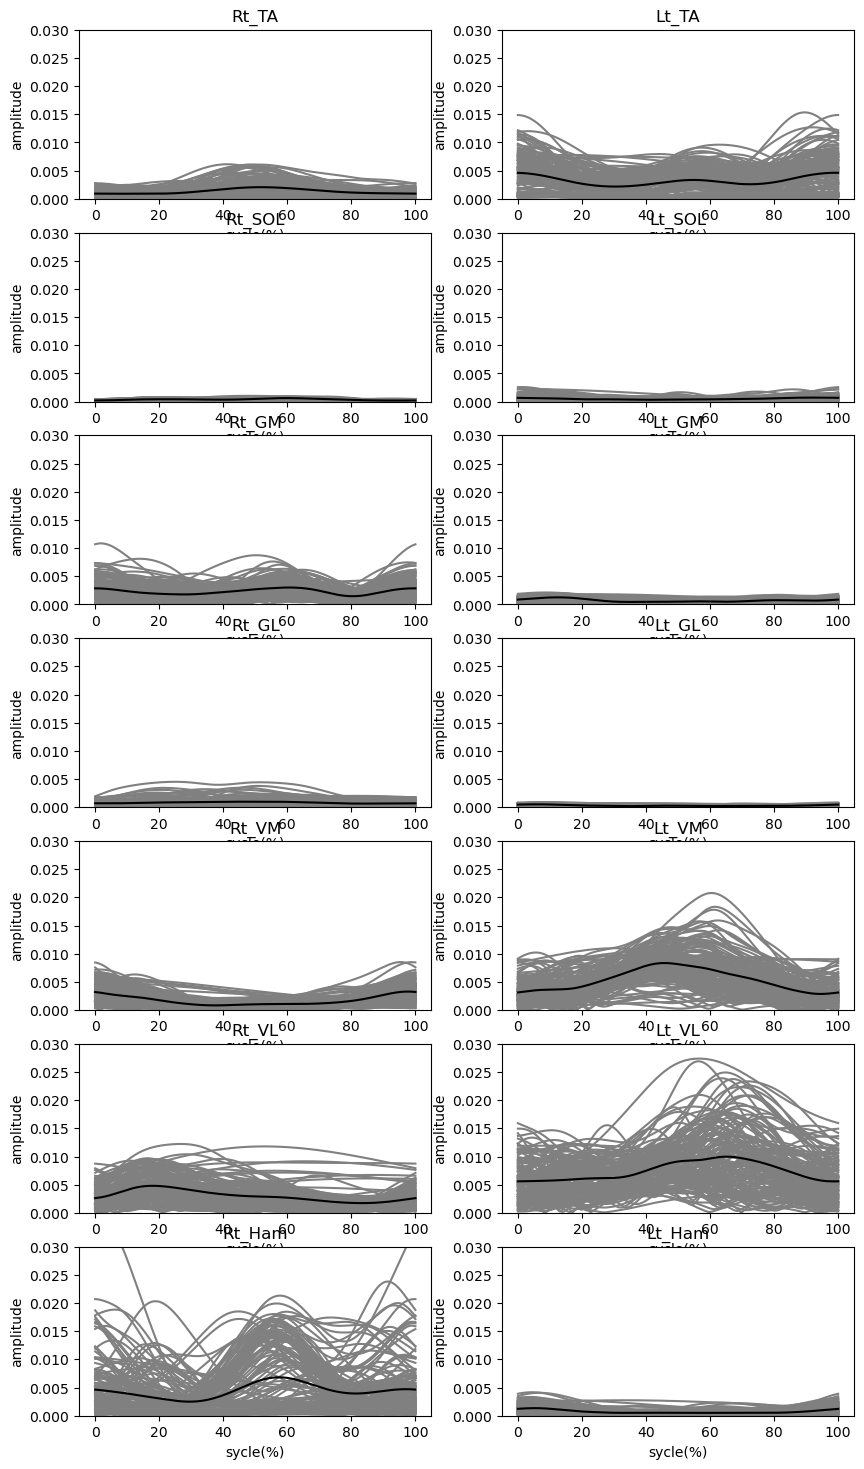

In [350]:
emg.plot_raw(ymax=0.03, ymin=0, add_mean=True)

In [136]:
fname = "../data/Data_original/Elderly/EMG/sub05/RAS100.mat"
emg_100 = EMG(fname)
fname = "../data/Data_original/Elderly/EMG/sub05/RAS110.mat"
emg_110 = EMG(fname)

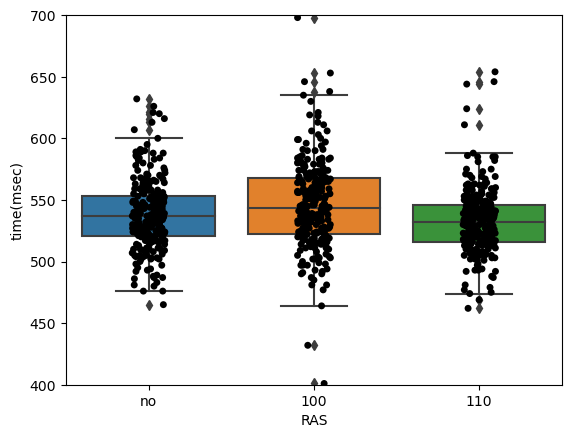

In [137]:
EMG.comp_box([emg,emg_100, emg_110], labels=["no","100","110"], ymin = 400, ymax = 700)

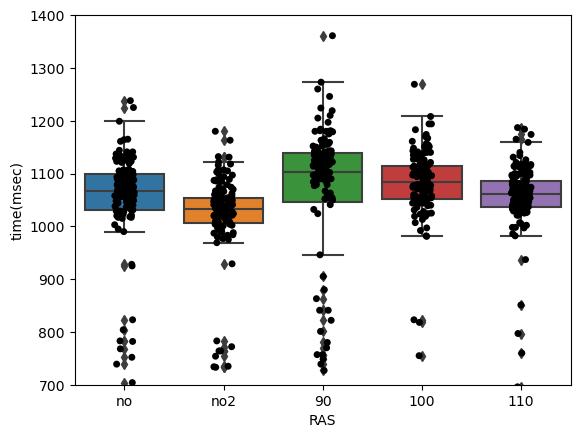

In [354]:
import os
# os.chdir("/Users/bmhi/Desktop/research/script/")
os.chdir("/Users/koji/Desktop/research/script/")
fname = "../data/Data_original/Elderly/EMG/sub05/noRAS1.mat"
# fname = "../data/Data_original/Elderly/EMG/sub05/RAS100.mat"
# emg = pp.EMG(fname)
emg_no = EMG(fname)
fname = "../data/Data_original/Elderly/EMG/sub05/noRAS2.mat"
emg_no2 = EMG(fname)
fname = "../data/Data_original/Elderly/EMG/sub05/RAS90.mat"
emg_90 = EMG(fname)
fname = "../data/Data_original/Elderly/EMG/sub05/RAS100.mat"
emg_100 = EMG(fname)
fname = "../data/Data_original/Elderly/EMG/sub05/RAS110.mat"
emg_110 = EMG(fname)

EMG.comp_box([emg_no, emg_no2, emg_90, emg_100, emg_110], labels=["no","no2","90","100","110"], ymin = 700, ymax = 1400)

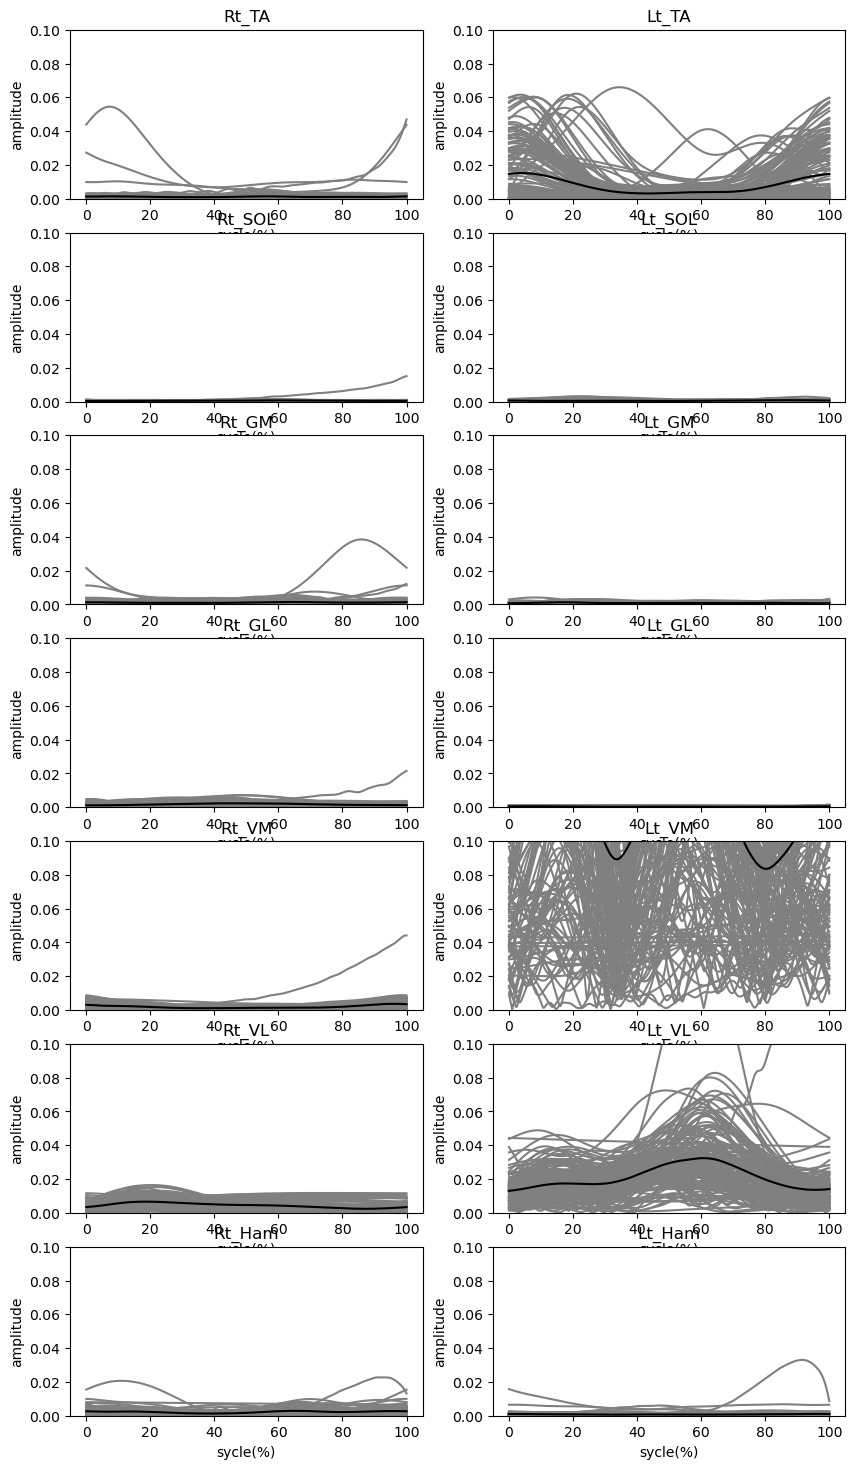

In [367]:
emg_90.filering(degree=4, high_freq=0.5,low_freq=250)
emg_90.smooth()
emg_90.epoching(n=1000)
emg_90.plot_raw(ymax=0.1, ymin=0, add_mean=True)
plt.savefig("../misc/plot/1216/emg_signal_90.png")

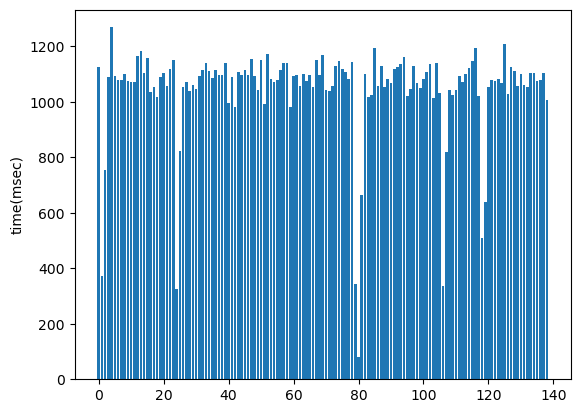

In [362]:
emg_100.plot_bar()

<AxesSubplot:>

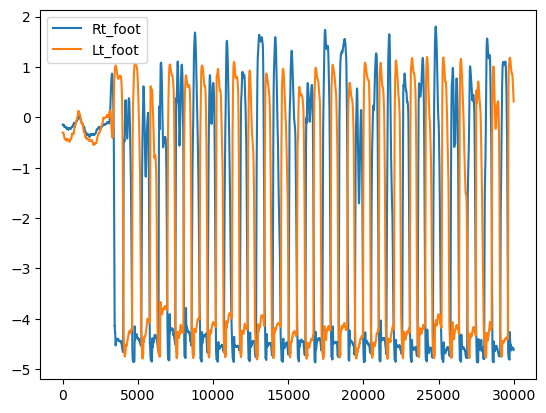

In [133]:
emg.foot_sensor.iloc[:30000,:].plot()

In [142]:
emg.filering(degree=4,high_freq=0.5,low_freq=250)

In [42]:
# emg.filtered

In [43]:
# filt = emg.filtered
# filt.iloc[:10000].plot()

In [268]:
# emg.epoching(tmin=-0.5,tmax = 1.5)
emg.epoching(n=1000)

In [270]:
emg.lln_epochs.shape

(267, 1000, 14)

In [255]:
emg.lln_list()

TypeError: EMG.approx() takes 3 positional arguments but 4 were given

In [216]:
len(emg.epochs[1])

2000

In [205]:
emg.epochs.shape

(267, 2000, 14)

In [187]:
emg.epochs[2].shape

(621, 14)

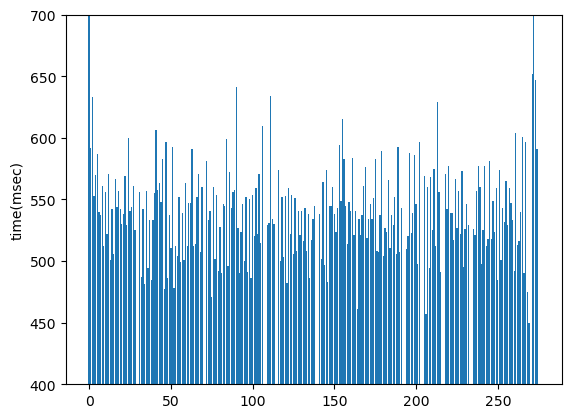

In [63]:
emg.plot_bar(ymin=400, ymax=700)

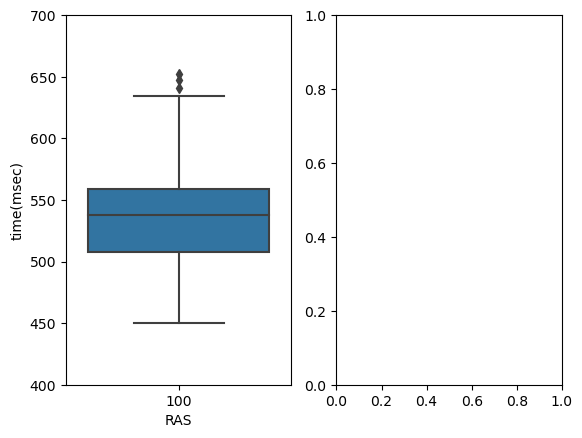

In [92]:
fig, ax = plt.subplots(1,2)
emg.plot_box(ymin=400, ymax=700,labels=100, ax = ax[0], strip=False)

In [74]:
len(emg.epochs)

276

In [79]:
idx = emg.events[emg.events==1].index

In [85]:
length = []
for i in range(len(idx)):
    if i == len(idx)-1:
        break
    print(idx[i+1]-idx[i])
    length.append(idx[i+1]-idx[i])

4039
592
633
553
570
587
540
537
561
512
556
522
571
501
542
506
567
544
557
542
530
538
569
529
600
541
544
561
525
259
267
556
487
542
481
557
494
533
485
533
555
606
558
563
548
583
477
597
486
537
511
593
478
512
504
552
499
539
501
563
512
547
547
591
512
514
552
571
507
560
391
158
581
533
541
471
560
502
554
492
528
490
546
545
599
496
572
543
556
558
641
527
490
524
546
500
552
491
550
486
554
520
559
522
571
515
610
253
275
529
531
634
534
530
253
354
574
500
552
503
553
482
559
522
554
506
551
508
541
521
541
516
543
508
538
486
517
534
545
261
245
538
502
564
497
574
483
545
545
560
538
524
543
594
549
615
583
545
514
548
541
584
521
541
461
534
521
537
561
576
519
534
546
534
551
583
508
507
537
589
504
527
524
566
511
537
529
552
506
593
507
543
327
194
510
520
588
523
539
586
546
498
597
315
183
569
457
560
494
568
525
575
512
629
556
491
332
211
571
542
577
539
539
517
567
527
557
522
573
495
526
546
529
276
242
526
521
557
577
560
498
525
577
512
518
581
518
549
524
559

(100.0, 700.0)

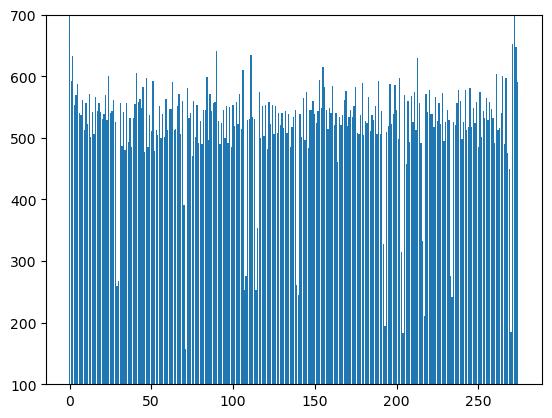

In [89]:
import matplotlib.pyplot as plt
plt.bar(range(len(length)),length)
plt.ylim(100,700)

In [75]:
for ep in emg.epochs:
    print(len(ep))

4039
592
633
553
570
587
540
537
561
512
556
522
571
501
542
506
567
544
557
542
530
538
569
529
600
541
544
561
525
259
267
556
487
542
481
557
494
533
485
533
555
606
558
563
548
583
477
597
486
537
511
593
478
512
504
552
499
539
501
563
512
547
547
591
512
514
552
571
507
560
391
158
581
533
541
471
560
502
554
492
528
490
546
545
599
496
572
543
556
558
641
527
490
524
546
500
552
491
550
486
554
520
559
522
571
515
610
253
275
529
531
634
534
530
253
354
574
500
552
503
553
482
559
522
554
506
551
508
541
521
541
516
543
508
538
486
517
534
545
261
245
538
502
564
497
574
483
545
545
560
538
524
543
594
549
615
583
545
514
548
541
584
521
541
461
534
521
537
561
576
519
534
546
534
551
583
508
507
537
589
504
527
524
566
511
537
529
552
506
593
507
543
327
194
510
520
588
523
539
586
546
498
597
315
183
569
457
560
494
568
525
575
512
629
556
491
332
211
571
542
577
539
539
517
567
527
557
522
573
495
526
546
529
276
242
526
521
557
577
560
498
525
577
512
518
581
518
549
524
559

914
689
719
530
597
374
174
581
516
574
603
666
502
591
525
555
523
555
542
558
536
539
526
547
533
540
551
616
581
602
507
598
622
535
518
518
497
557
492
527
511
577
471
633
480
577
540
580
566
585
327
203
620
488
564
486
585
506
534
514
546
482
563
513
581
497
618
518
623
513
599
530
555
548
567
527
571
541
555
517
624
466
531
486
605
463
518
532
576
505
593
502
459
153
513
584
559
595
494
601
516
528
517
633
460
532
561
613
493
589
480
591
518
560
532
583
552
588
540
599
510
472
522
573
531
567
500
558
506
594
484
590
504
592
512
542
549
602
534
564
541
629
473
570
478
561
507
550
519
610
523
625
523
594
497
609
481
601
541
602
343
79
145
518
492
610
488
531
492
533
579
615
472
586
511
617
463
591
483
600
496
572
535
584
539
588
544
591
515
646
516
507
521
525
517
613
485
583
472
578
496
587
520
589
525
612
511
502
539
601
486
545
336
240
578
527
517
504
520
509
535
479
615
510
561
522
578
550
571
573
576
536
658
510
511
508
103
537
497
558
514
565
511
566
526
555
498
569
562
646
5

(100.0, 700.0)

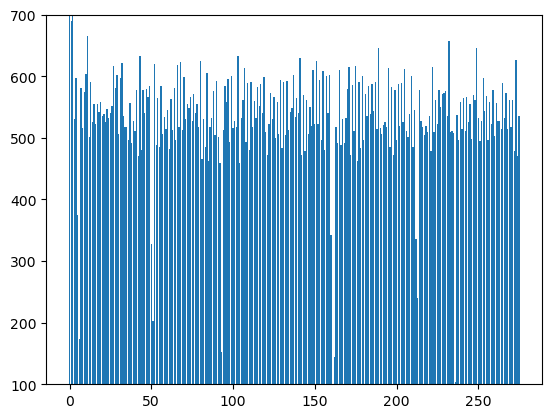

In [91]:
fname = "../data/Data_original/Elderly/EMG/sub05/RAS100.mat"
emg_100 = EMG(fname)
emg_100.filering(degree=4,high_freq=0.5,low_freq=250)

idx = emg_100.events[emg_100.events==1].index

length = []
for i in range(len(idx)):
    if i == len(idx)-1:
        break
    print(idx[i+1]-idx[i])
    length.append(idx[i+1]-idx[i])

plt.bar(range(len(length)),length)
plt.ylim(100,700)

In [105]:
hoge = pd.DataFrame({
    "a" : 1,
    "b" : np.arange(10)
})
hoge

,a,b
0,1,0
1,1,1
2,1,2
3,1,3
4,1,4
5,1,5
6,1,6
7,1,7
8,1,8
9,1,9


In [164]:
a=1
if a:
    print(100)

100
